**NOTES**
- Topic: How advances in contact tracing technology used during the COVID-19 pandemic can be used to predict future disease epidemics and pandemics
- Imported datasets are from your Google Drive

**Prepared by:**
- Email: wiener baalls

# 0. Import packages

In [1]:
# Install external libraries
%pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=c65b9c6d25921f1baa46e16360b91fbc361c914b45978c60cfacb0ca806ab5cd
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [2]:
# Import needed libraries
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Shorten KaplanMeierFitter() function
kmf = KaplanMeierFitter()

In [3]:
# Import Google Drive directory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import and preview the DataFrame

In [4]:
# Import DataFrame
file_path = '/content/drive/MyDrive/Colab Notebooks/colab-files/figshare_taiwan_covid.xlsx'
df_ind = pd.read_excel(file_path, sheet_name='Individual Data')

In [5]:
# View a preview of the DataFrame
df_ind.tail(5)

,id,abroad/local,infection_source,visited_countries/cities,date_of_departure_1,date_of_arrival_1,visited_country/city_1,date_of_departure_2,date_of_arrival_2,visited_country/city_2,...,date_of_contact_with_infected_case,source_infected_cases_all,source_infected_case,earliest_infection_date,negative_test_date_1,negative_test_date_2,negative_test_date_3,negative_test_date_4,detail,source
573,5,Abroad,China,Wuhan,NaN,NaN,Wuhan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,"business;\nOn the 26th, there were 119 newly n...",https://www.cdc.gov.tw/Bulletin/Detail/d-4jLlO...
574,4,Abroad,China,"Wuhan, Europe",2020-01-13,NaN,Wuhan,2020-01-15,2020-01-16,Europe,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,travelling;\n新增1例境外移入嚴重特殊傳染性肺炎病例，為北部50多歲女性，1月1...,https://www.cdc.gov.tw/Bulletin/Detail/d-4jLlO...
575,3,Abroad,China,Wuhan,NaN,NaN,Wuhan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,"business; \nAs of 4:00 pm on January 24, there...",https://www.cdc.gov.tw/Bulletin/Detail/d-4jLlO...
576,2,Abroad,China,Travel to Taiwan,NaN,NaN,Travel to Taiwan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,travelling\n50多歲男性國人(案2)，皆為1月21日入境；案1為1月23日因發燒...,https://www.cdc.gov.tw/Bulletin/Detail/d-4jLlO...
577,1,Abroad,China,Wuhan,NaN,NaN,Wuhan,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,business\n50多歲中國籍女性(案1)，皆為1月21日入境；案2於1月20日出現感冒...,https://www.cdc.gov.tw/Bulletin/Detail/d-4jLlO...


In [6]:
# View variables
df_ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 40 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   id                                  578 non-null    int64         
 1   abroad/local                        577 non-null    object        
 2   infection_source                    474 non-null    object        
 3   visited_countries/cities            472 non-null    object        
 4   date_of_departure_1                 440 non-null    object        
 5   date_of_arrival_1                   39 non-null     object        
 6   visited_country/city_1              471 non-null    object        
 7   date_of_departure_2                 77 non-null     object        
 8   date_of_arrival_2                   9 non-null      object        
 9   visited_country/city_2              30 non-null     object        
 10  date_of_departure_3       

# 2. Definte State Mapping Logic

In [7]:
# Convert all date columns to datetime objects
date_cols = ['date_of_departure_1', 'date_of_arrival_1', 'date_of_departure_2', 'date_of_arrival_2', 'date_of_departure_3',
             'date_of_arrival_3', 'date_of_departure_4', 'date_of_arrival_4', 'date_of_transit', 'date_of_arrival_to_taiwan',
             'onset_of_symptom', 'report_to_cdc', 'confirmed_date', 'icu', 'recovery', 'death_date',
             'date_of_contact_with_infected_case', 'earliest_infection_date', 'negative_test_date_1', 'negative_test_date_2',
             'negative_test_date_3', 'negative_test_date_4']
for col in date_cols:
    df_ind[col] = pd.to_datetime(df_ind[col], errors='coerce', utc='True')

# View
df_ind['date_of_departure_1'].value_counts()

,count
date_of_departure_1,
2020-01-01 00:00:00+00:00,22
2020-02-01 00:00:00+00:00,16
2020-03-01 00:00:00+00:00,6
2019-12-01 00:00:00+00:00,5
2020-09-01 00:00:00+00:00,3
2019-09-01 00:00:00+00:00,3
2019-11-01 00:00:00+00:00,3
2020-06-01 00:00:00+00:00,2
2020-04-01 00:00:00+00:00,2


In [8]:
# Create Infection Onset to Symptom variable
df_ind['duration_IA_to_IS'] = (df_ind['onset_of_symptom'] - df_ind['earliest_infection_date']).dt.days
# Create Symptom Onset to Confirmation variable
df_ind['duration_IS_to_C'] = (df_ind['confirmed_date'] - df_ind['onset_of_symptom']).dt.days
# Create Confirmed Onset to ICU variable
df_ind['duration_C_to_IC'] = (df_ind['icu'] - df_ind['confirmed_date']).dt.days
# Create Confirmed Onset to Recovery variable
df_ind['duration_C_to_R'] = (df_ind['recovery'] - df_ind['confirmed_date']).dt.days
# Create Confirmed Onset to Death variable
df_ind['duration_C_to_D'] = (df_ind['death_date'] - df_ind['confirmed_date']).dt.days

# Filter out invalid observations
# df_ind = df_ind[df_ind['duration_IA_to_IS'] >= 0]
# df_ind = df_ind[df_ind['duration_IS_to_C'] >= 0]
# df_ind = df_ind[df_ind['duration_C_to_IC'] >= 0]
# df_ind = df_ind[df_ind['duration_C_to_R'] >= 0]
# df_ind = df_ind[df_ind['duration_C_to_D'] >= 0]

df_ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   id                                  578 non-null    int64              
 1   abroad/local                        577 non-null    object             
 2   infection_source                    474 non-null    object             
 3   visited_countries/cities            472 non-null    object             
 4   date_of_departure_1                 74 non-null     datetime64[ns, UTC]
 5   date_of_arrival_1                   39 non-null     datetime64[ns, UTC]
 6   visited_country/city_1              471 non-null    object             
 7   date_of_departure_2                 77 non-null     datetime64[ns, UTC]
 8   date_of_arrival_2                   9 non-null      datetime64[ns, UTC]
 9   visited_country/city_2              30 non-

In [9]:
# Create boolean variable columns with the condition if the corresponding transitions occurred
df_ind['event_IA_to_IS'] = df_ind['onset_of_symptom'].notnull().astype(int)
df_ind['event_IS_to_C'] = df_ind['confirmed_date'].notnull().astype(int)
df_ind['event_C_to_IC'] = df_ind['icu'].notnull().astype(int)
df_ind['event_C_to_R'] = df_ind['recovery'].notnull().astype(int)
df_ind['event_C_to_D'] = df_ind['death_date'].notnull().astype(int)

# Verify
print(df_ind['event_IA_to_IS'].value_counts())
print(df_ind['event_IS_to_C'].value_counts())
print(df_ind['event_C_to_IC'].value_counts())
print(df_ind['event_C_to_R'].value_counts())
print(df_ind['event_C_to_D'].value_counts())

event_IA_to_IS
1    442
0    136
Name: count, dtype: int64
event_IS_to_C
1    578
Name: count, dtype: int64
event_C_to_IC
0    520
1     58
Name: count, dtype: int64
event_C_to_R
0    499
1     79
Name: count, dtype: int64
event_C_to_D
0    571
1      7
Name: count, dtype: int64


In [10]:
# Extract filtered observations into individual DataFrames
df_clean_IA_to_IS = df_ind.dropna(subset='duration_IA_to_IS')
df_clean_IS_to_C = df_ind.dropna(subset='duration_IS_to_C')
df_clean_C_to_IC = df_ind.dropna(subset='duration_C_to_IC')
df_clean_C_to_R = df_ind.dropna(subset='duration_C_to_R')
df_clean_C_to_D = df_ind.dropna(subset='duration_C_to_D')

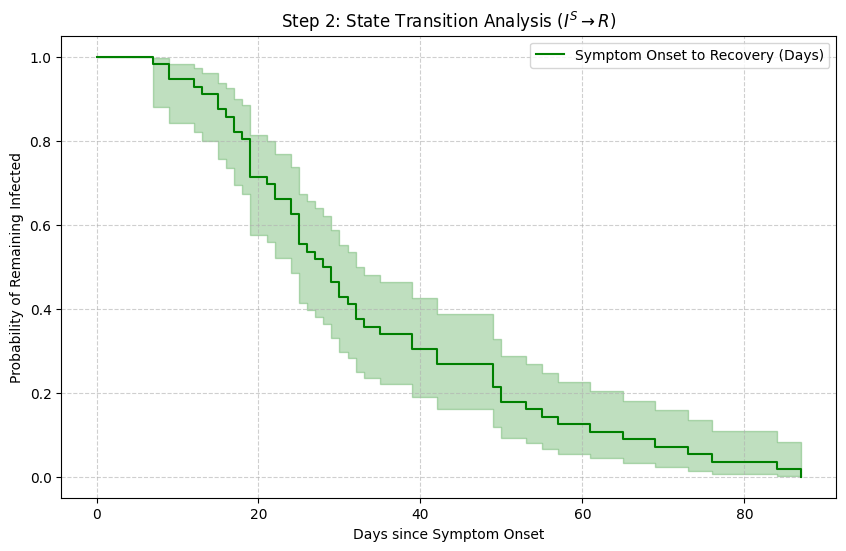

--- FINAL RESULTS ---
Median time from Symptoms to Recovery: 28.0 days


In [28]:
# 1. Combine Onset-to-Confirmation and Confirmation-to-Recovery
# This gives us the full Is -> R transition the advisor asked for.
df_ind['total_recovery_time'] = df_ind['duration_IS_to_C'] + df_ind['duration_C_to_R']

# 2. Filter out the negatives or NaNs (sometimes data has errors)
df_survival = df_ind[df_ind['total_recovery_time'] > 0].copy()

# 3. Fit the Kaplan-Meier Curve
kmf.fit(df_survival['total_recovery_time'],
        event_observed=df_survival['event_C_to_R'], # Using the 'Recovery' event marker
        label='Symptom Onset to Recovery (Days)')

# 4. Plot the result
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(color='green')
plt.title('Step 2: State Transition Analysis ($I^S \\rightarrow R$)')
plt.xlabel('Days since Symptom Onset')
plt.ylabel('Probability of Remaining Infected')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 5. Output the final answer for your report
median_days = kmf.median_survival_time_
print(f"--- FINAL RESULTS ---")
print(f"Median time from Symptoms to Recovery: {median_days} days")

Visualization

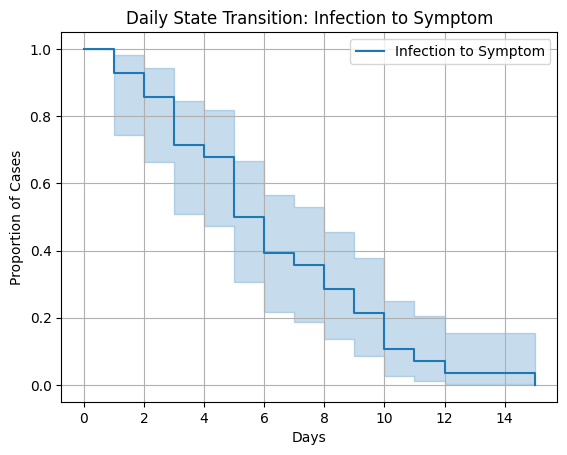

In [11]:
# Use kmf to estimate Infection to Symptom survival function
kmf.fit(
    durations = df_clean_IA_to_IS['duration_IA_to_IS'],
    event_observed = df_clean_IA_to_IS['event_IA_to_IS'],
    label = 'Infection to Symptom'
)

# View
kmf.plot_survival_function()
plt.title('Daily State Transition: Infection to Symptom')
plt.xlabel('Days')
plt.ylabel('Proportion of Cases')
plt.grid(True)
plt.show()

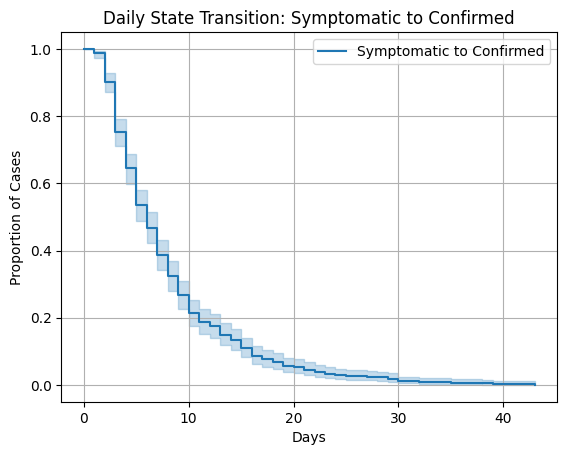

In [12]:
# Use kmf to estimate Symptomatic to Confirmed survival function
kmf.fit(
    durations = df_clean_IS_to_C['duration_IS_to_C'],
    event_observed = df_clean_IS_to_C['event_IS_to_C'],
    label = 'Symptomatic to Confirmed'
)

# View
kmf.plot_survival_function()
plt.title('Daily State Transition: Symptomatic to Confirmed')
plt.xlabel('Days')
plt.ylabel('Proportion of Cases')
plt.grid(True)
plt.show()

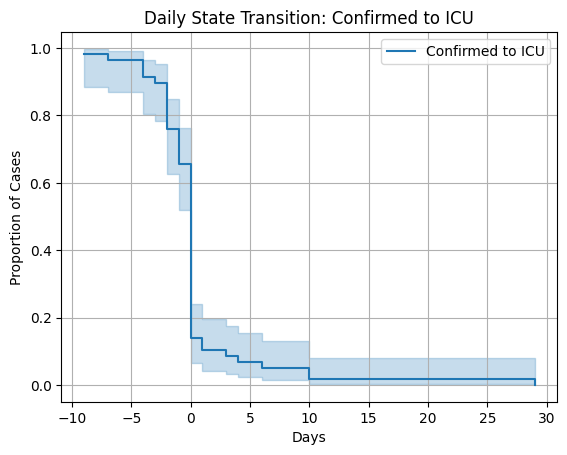

In [13]:
# Use kmf to estimate Confirmed to ICU survival function
kmf.fit(
    durations = df_clean_C_to_IC['duration_C_to_IC'],
    event_observed = df_clean_C_to_IC['event_C_to_IC'],
    label = 'Confirmed to ICU'
)

# View
kmf.plot_survival_function()
plt.title('Daily State Transition: Confirmed to ICU')
plt.xlabel('Days')
plt.ylabel('Proportion of Cases')
plt.grid(True)
plt.show()

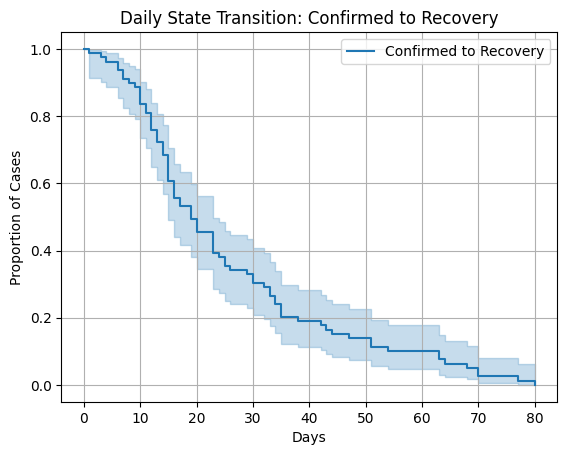

In [14]:
# Use kmf to estimate Confirmed to Recovery survival function
kmf.fit(
    durations = df_clean_C_to_R['duration_C_to_R'],
    event_observed = df_clean_C_to_R['event_C_to_R'],
    label = 'Confirmed to Recovery'
)

# View
kmf.plot_survival_function()
plt.title('Daily State Transition: Confirmed to Recovery')
plt.xlabel('Days')
plt.ylabel('Proportion of Cases')
plt.grid(True)
plt.show()

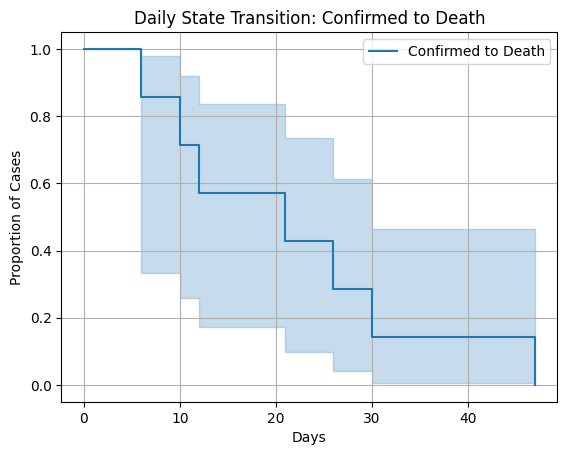

In [15]:
# Use kmf to estimate Confirmed to Death survival function
kmf.fit(
    durations = df_clean_C_to_D['duration_C_to_D'],
    event_observed = df_clean_C_to_D['event_C_to_D'],
    label = 'Confirmed to Death'
)

# View
kmf.plot_survival_function()
plt.title('Daily State Transition: Confirmed to Death')
plt.xlabel('Days')
plt.ylabel('Proportion of Cases')
plt.grid(True)
plt.show()

# 3. Reconstruct the Contact Network

In [16]:
# TODO: put this on the top
import networkx as nx

Initialization

In [17]:
# Load edge list, individual data are the nodes
df_edg = pd.read_excel(file_path, sheet_name='Edge List')

# Initialize a Mixed Graph (directed and undirected edges)
G = nx.MultiDiGraph()

Node & Attribute Mapping

In [18]:
# Iterate through the individual data to add nodes
for index, row in df_ind.iterrows():
    node_id = str(row['id'])

    # Create a dictionary of attributes for this person
    attributes = {
        'age': row['age'],
        'gender': row['gender'],
        'confirmed_date': row['confirmed_date'],
        'asymptomatic_date': row['earliest_infection_date'], # Proxy for infection start
        # 'is_infected': str(row['id']).startswith('I') # boolean flag based on ID convention
    }

    # Add node to graph with attributes
    G.add_node(node_id, **attributes)

print(f"Graph initialized with {G.number_of_nodes()} nodes")

Graph initialized with 578 nodes


Edge Reconstruction

In [19]:
# Iterate through the edge list to reconstruct network
for index, row in df_edg.iterrows():
    source = str(row['source'])
    target = str(row['target'])
    interaction_type = int(row['interaction'])
    is_directed = bool(row['directed'])

    # Define edge attributes
    edge_attrs = {
        'interaction': interaction_type,
        'directed_path': is_directed
    }

    if is_directed:
        # If directed=True, it is a transmission path (Source -> Target)
        G.add_edge(source, target, color='red', **edge_attrs)
    else:
        # If directed=False, it is a contact without known transmission direction
        # represent undirected contacts by adding edges both directions
        G.add_edge(source, target, color='grey', **edge_attrs)
        G.add_edge(target, source, color='grey', **edge_attrs)

print(f"Graph reconstructed with {G.number_of_edges()} edges")

Graph reconstructed with 91983 edges


Analysis & Metrics

In [20]:
# Convert to undirected to find connected components (clusters)
G_undirected = G.to_undirected()

# Get all clusters (connected components)
clusters = list(nx.connected_components(G_undirected))

# Calculate stats
num_clusters = len(clusters)
cluster_sizes = [len(c) for c in clusters]
max_cluster = max(cluster_sizes)

print(f"Total Clusters Identified: {num_clusters}") # ~152
print(f"Largest Cluster Size: {max_cluster}")      # ~1,898

Total Clusters Identified: 152
Largest Cluster Size: 1898


Secondary Attack Rate (SAR) by Interaction

In [21]:
# Dictionary mapping interaction codes to names
interaction_map = {
    0: 'Couple', 1: 'Parent/Child', 2: 'Grandparent/Grandchild', 3: 'Brother/Sister',
    4: 'Family', 5: 'Friend', 6: 'Live together', 7: 'The same flight',
    8: 'Flight nearby seat', 9: 'Travel together', 10: 'School', 11: 'Car',
    12: 'Hotel', 13: 'Quarantine hotel', 14: 'Coworker', 15: 'Hospital',
    16: 'Panshi Ship', 17: 'Coral Princess', 18: 'Other'
}

# 1. Count Total Contacts per Interaction Type
total_counts = df_edg['interaction'].value_counts().sort_index()

# 2. Count Infection Paths (Directed Edges) per Interaction Type
# edges where transmission actually occurred
infection_counts = df_edg[df_edg['directed'] == True]['interaction'].value_counts().sort_index()

# 3. Combine into a DataFrame for SAR Analysis
sar_df = pd.DataFrame({
    'Interaction': [interaction_map.get(i, f'Type {i}') for i in total_counts.index],
    'Total_Contacts': total_counts.values,
    # Use 'get' to handle cases where an interaction type might have 0 infections
    'Infection_Events': [infection_counts.get(i, 0) for i in total_counts.index]
})

# Calculate Risk (Proxy for SAR)
sar_df['Transmission_Risk_Pct'] = (sar_df['Infection_Events'] / sar_df['Total_Contacts']) * 100

print(sar_df.sort_values('Transmission_Risk_Pct', ascending=False))

               Interaction  Total_Contacts  Infection_Events  \
2   Grandparent/Grandchild               2                 1   
6            Live together              40                 6   
1             Parent/Child               7                 1   
0                   Couple              32                 4   
5                   Friend               8                 1   
15                Hospital              31                 3   
4                   Family              58                 4   
11                     Car             562                 1   
7          The same flight            5406                 7   
10                  School            1203                 1   
18                   Other           16446                 8   
3           Brother/Sister               2                 0   
8       Flight nearby seat             868                 0   
9          Travel together             805                 0   
13        Quarantine hotel              

Visualization

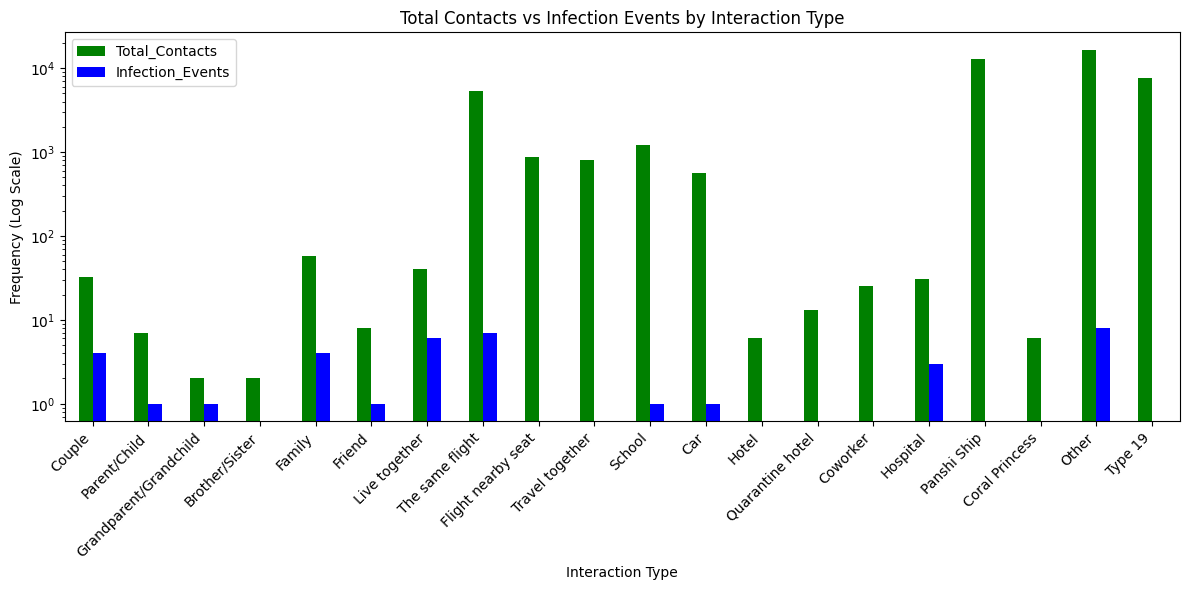

In [22]:
# View plot graph
ax = sar_df.plot(x='Interaction', y=['Total_Contacts', 'Infection_Events'], kind='bar',
                 figsize=(12, 6), color=['green', 'blue'], logy=True)

plt.title('Total Contacts vs Infection Events by Interaction Type')
plt.ylabel('Frequency (Log Scale)')
plt.xlabel('Interaction Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [29]:
# 1. Transitions from Infection to Symptoms to Confirmation
df_ind['duration_IA_to_IS'] = (df_ind['onset_of_symptom'] - df_ind['earliest_infection_date']).dt.days
df_ind['duration_IS_to_C'] = (df_ind['confirmed_date'] - df_ind['onset_of_symptom']).dt.days

# 2. Outcomes (Recovery, ICU, or Death)
df_ind['duration_C_to_IC'] = (df_ind['icu'] - df_ind['confirmed_date']).dt.days
df_ind['duration_C_to_R'] = (df_ind['recovery'] - df_ind['confirmed_date']).dt.days
df_ind['duration_C_to_D'] = (df_ind['death_date'] - df_ind['confirmed_date']).dt.days

# 3. The "Master Variable" for Step 2 (Symptom to Recovery)
# Ito yung kailangan ng Advisor: Is -> C -> R
df_ind['duration_IS_to_R'] = df_ind['duration_IS_to_C'] + df_ind['duration_C_to_R']

# 4. Cleaning (Uncommented for accuracy)
# Tinatanggal natin yung mga data entry errors (negative days)
df_ind = df_ind[(df_ind['duration_IS_to_C'] >= 0) | (df_ind['duration_IS_to_C'].isna())]
df_ind = df_ind[(df_ind['duration_C_to_R'] >= 0) | (df_ind['duration_C_to_R'].isna())]

print("✅ All variables (ICU, Recovery, Death) are now locked and loaded.")

✅ All variables (ICU, Recovery, Death) are now locked and loaded.


In [30]:
# --- CLUSTER IMPACT ANALYSIS ---
import numpy as np

# 1. Get the sizes of all 152 identified clusters
cluster_sizes = [len(c) for c in clusters]

# 2. Sort them to find the "Big Fish" (like that 1,898-person one)
sorted_clusters = sorted(cluster_sizes, reverse=True)

# 3. Calculate the 80/20 Rule: Do the top 10% of clusters cause most infections?
top_10_percent_count = max(1, int(len(sorted_clusters) * 0.1))
top_10_impact = sum(sorted_clusters[:top_10_percent_count])
total_infections = sum(sorted_clusters)
impact_pct = (top_10_impact / total_infections) * 100

print(f"--- SUPERSPEADER RESULTS ---")
print(f"Total Clusters: {len(clusters)}")
print(f"Largest Cluster Size: {max(cluster_sizes)} people")
print(f"The top 10% of clusters account for {impact_pct:.2f}% of all cases.")

--- SUPERSPEADER RESULTS ---
Total Clusters: 152
Largest Cluster Size: 1898 people
The top 10% of clusters account for 72.83% of all cases.


In [31]:
# --- FINAL SAR RANKING ---

# We use the sar_df we built earlier from the interaction_map
# We filter for types with more than 5 contacts to keep the math 'clean'
reliable_sar = sar_df[sar_df['Total_Contacts'] > 5].copy()

# Sort by the highest Transmission Risk Pct
reliable_sar = reliable_sar.sort_values('Transmission_Risk_Pct', ascending=False)

print("--- SECONDARY ATTACK RATE (SAR) RANKING ---")
print(reliable_sar[['Interaction', 'Total_Contacts', 'Infection_Events', 'Transmission_Risk_Pct']])

# Summary for the Advisor
top_risk = reliable_sar.iloc[0]['Interaction']
risk_val = reliable_sar.iloc[0]['Transmission_Risk_Pct']
print(f"\nCONCLUSION: '{top_risk}' is the highest risk environment with a {risk_val:.2f}% transmission rate.")

--- SECONDARY ATTACK RATE (SAR) RANKING ---
           Interaction  Total_Contacts  Infection_Events  \
6        Live together              40                 6   
1         Parent/Child               7                 1   
0               Couple              32                 4   
5               Friend               8                 1   
15            Hospital              31                 3   
4               Family              58                 4   
11                 Car             562                 1   
7      The same flight            5406                 7   
10              School            1203                 1   
18               Other           16446                 8   
8   Flight nearby seat             868                 0   
9      Travel together             805                 0   
13    Quarantine hotel              13                 0   
12               Hotel               6                 0   
14            Coworker              25                 0